In [55]:
import pandas as pd
import numpy as np
from pathlib import Path
import os.path
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
train_img_dir = Path('C://Users//Asus//Downloads//panda//PandasBears//Train')
test_img_dir = Path('C://Users//Asus//Downloads//panda//PandasBears//Test')

In [57]:
filepath = list(train_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
train_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

In [58]:
filepath = list(test_img_dir.glob(r'**/*.jpeg'))
Label = list(map(lambda x : os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "Filepath").astype(str)
Label = pd.Series(Label, name = 'Label')
test_df = pd.concat([filepath, Label], axis = 1).sample(frac = 1.0, random_state = 1).reset_index(drop = True)

In [59]:
train_df.shape

(500, 2)

In [60]:
test_df.shape

(100, 2)

In [61]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                           rotation_range = 30,
                                                           zoom_range = 0.2,
                                                           width_shift_range=0.1,
                                                           height_shift_range = 0.1,
                                                           horizontal_flip = True,
                                                           vertical_flip = False,
                                                           validation_split = 0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [62]:
train_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'training')
val_img = train_gen.flow_from_dataframe(dataframe = train_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = True,
                                         seed = 42,
                                         subset = 'validation')
test_img = test_gen.flow_from_dataframe(dataframe = test_df,
                                         x_col = 'Filepath',
                                         y_col = 'Label',
                                         target_size = (224,224),
                                         color_mode = 'rgb',
                                         class_mode = 'binary',
                                         batch_size = 32,
                                         shuffle = False)

Found 400 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [64]:
inputs = tf.keras.Input(shape = (224,224,3))
x = tf.keras.layers.Conv2D(filters = 16, kernel_size = (3,3),activation = 'relu')(inputs)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu')(x)
x = tf.keras.layers.MaxPool2D()(x)
x = tf.keras.layers.GlobalAvgPool2D()(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer = 'adam',
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])
history = model.fit(train_img, validation_data = val_img,
                   epochs = 100,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                               patience = 5,
                                                               restore_best_weights = True))

Epoch 1/100
13/13 [==============================] - 10s 664ms/step - loss: 0.6892 - accuracy: 0.5225 - val_loss: 0.6810 - val_accuracy: 0.4900
Epoch 2/100
13/13 [==============================] - 9s 654ms/step - loss: 0.6554 - accuracy: 0.6975 - val_loss: 0.6088 - val_accuracy: 0.9800
Epoch 3/100
13/13 [==============================] - 10s 770ms/step - loss: 0.5363 - accuracy: 0.9125 - val_loss: 0.4013 - val_accuracy: 0.9800
Epoch 4/100
13/13 [==============================] - 10s 780ms/step - loss: 0.3196 - accuracy: 0.9475 - val_loss: 0.1628 - val_accuracy: 0.9900
Epoch 5/100
13/13 [==============================] - 10s 766ms/step - loss: 0.1610 - accuracy: 0.9600 - val_loss: 0.1034 - val_accuracy: 0.9800
Epoch 6/100
13/13 [==============================] - 11s 810ms/step - loss: 0.0820 - accuracy: 0.9750 - val_loss: 0.0554 - val_accuracy: 0.9900
Epoch 7/100
13/13 [==============================] - 12s 899ms/step - loss: 0.0564 - accuracy: 0.9825 - val_loss: 0.0358 - val_accuracy: 

In [65]:
results = model.evaluate(test_img, verbose = 0)
print(f'Test Loss : {round(results[0], 3)}')
print(f'Test Accuracy : {round(results[1], 4)*100}%')

Test Loss : 0.045
Test Accuracy : 97.0%


4/4 [==============================] - 1s 85ms/step


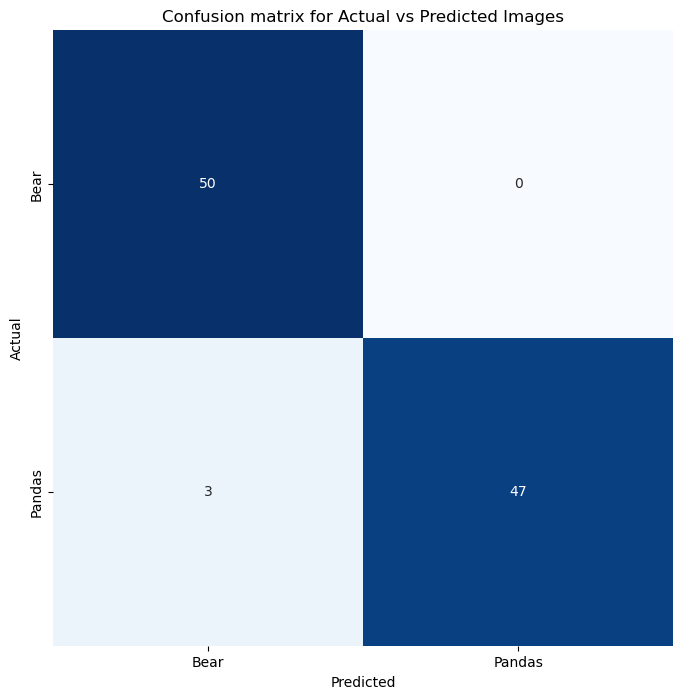

Classification Report---------->
               precision    recall  f1-score   support

        Bear       0.94      1.00      0.97        50
      Pandas       1.00      0.94      0.97        50

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100



In [67]:
test_img_pred = (model.predict(test_img) >= 0.5).astype(np.int)
cm = confusion_matrix(test_img.labels, test_img_pred, labels =[0,1])
clr = classification_report(test_img.labels, test_img_pred, labels = [0,1], target_names= ['Bear','Pandas'])
plt.figure(figsize = (8,8))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, cmap = 'Blues')
plt.title('Confusion matrix for Actual vs Predicted Images')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = [0.5, 1.5], labels= ['Bear','Pandas'])
plt.yticks(ticks= [0.5, 1.5], labels= ['Bear','Pandas'])
plt.show()
print('Classification Report---------->\n',clr)
                            

In [68]:
model.save('pandas.h5')